In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis

In [18]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
# general_vals_dict["wx_amps"]=[1.0, .5, 0.5, 1]
q1.ef_amp = 0.5
print(f"{q1}\n{q2}")

Qubit(ef_ssm=-0.1859, qubit_id=q1, ef_time=77, ro_amp=0.6, ge_ssm=-0.114, ro_freq=6.72742, ro_dur=4000, ROIF=0.10272000000000059, IQ_angle=205, qubit_thr=[-10000, -600], RO_LO_pwr=16, RO_IF=None, ef_amp=0.5, ge_time=66.625, RO_LO=6.6247, ge_amp=0.5)
Qubit(ef_ssm=-0.224, qubit_id=q2, ef_time=None, ro_amp=0.4, ge_ssm=-0.154, ro_freq=6.6556, ro_dur=4000, ROIF=0.030899999999999928, IQ_angle=85, qubit_thr=[-10000, 1900], RO_LO_pwr=16, RO_IF=None, ef_amp=1, ge_time=40.15374412400174, RO_LO=6.6247, ge_amp=1)


In [19]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [20]:
def run_rabi(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ef(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 4000
Buffers per acquistion: 67
DAQ samples per pattern: 8192
0, No error
Capturing 67 buffers. Press <enter> to abort
Capture completed in 22.750470 sec
Captured 67 buffers (2.944994 buffers per sec)
Captured 205824 records (9047.021916 records per sec)
Transferred 3372220416 bytes (148226407.076889 bytes per sec)


<Figure size 800x800 with 0 Axes>

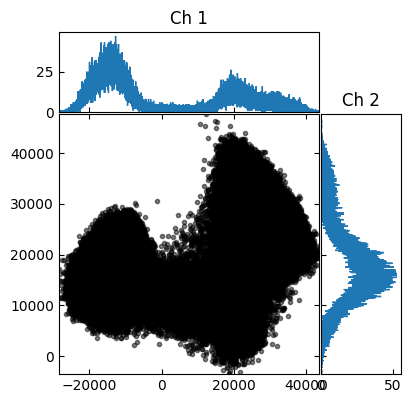

<Figure size 800x800 with 0 Axes>

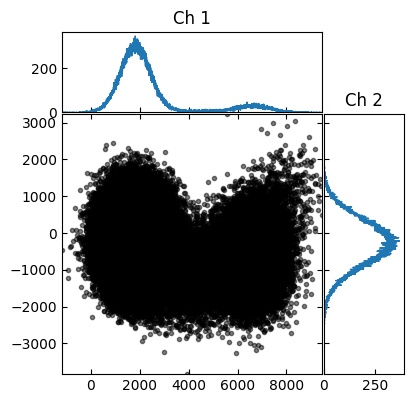

In [21]:
num_steps = 51
reps = 500 * 8
sweep_time = 2000
values, IQ_df = run_rabi(q1, q2, general_vals_dict, num_steps, sweep_time, reps)

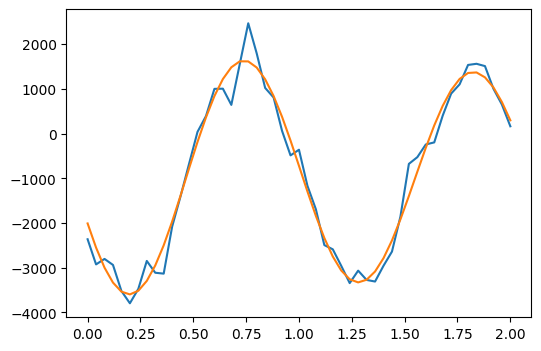



  freq: 0.9220845506754464 +/- 0.007329910079118435
 gamma: 0.09730601619150377 +/- 0.04375536481263472
   amp: -2736.4722190968087 +/- 131.78157449280428
 phase: 23.618378363421925 +/- 2.8707130297917933
offset: -913.185387252858 +/- 48.05650527451962
pi_pulse time: 0.5422496230239835 +/- 0.007329910079118435
π_ge time = 542.2496230239835 ns


In [22]:
plotting.rabi_plot(sweep_time, num_steps, values, qubit_num=1)